<a href="https://www.kaggle.com/code/tomkarlsson/playground-s04e03-001?scriptVersionId=165119647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

In [3]:
# Display
print(f'train_data.shape: {train_data.shape:}, test_data.shape{test_data.shape}')
print(f'Number of dtypes: {pd.unique(train_data.dtypes)}')
print(f'Number of NA values: {train_data.isna().sum().sum()}')

train_data.shape: (19219, 34), test_data.shape(12814, 27)
Number of dtypes: [dtype('int64') dtype('float64')]
Number of NA values: 0


In [4]:
# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
prediction_categories
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

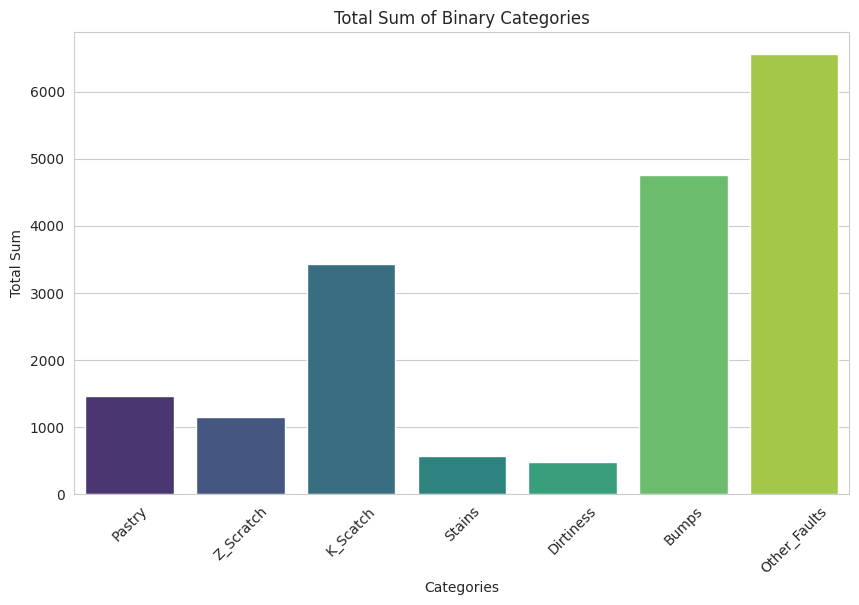

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Check
#sns.countplot(data=y_full)

# Calculate the total sum for each category (column)
totals = np.array(y_full.sum())

# Get the column names (categories)
categories = np.array(y_full.columns)

# Create a bar plot using seaborn
sns.set_style("whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size

# Create the bar plot
sns.barplot(x=categories, y=totals, palette="viridis")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Total Sum")
plt.title("Total Sum of Binary Categories")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()

**Note:** We can see that our training data is unbalanced.

# Vanilla NN
I will start by creating a NN model using default values. It will provide the base result upon which we can try to improve later on. 

In [6]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

def get_model_vanilla(learning_rate=0.3) -> Sequential:
    # Create a Sequential model
    model = Sequential([
        Dense(num_features, activation='relu', input_shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy','auc'])

    # Name the model
    model.name = 'Vanilla' 
    return model

model = get_model_vanilla()
# Print model summary
model.summary()

2024-03-02 11:03:50.560416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 11:03:50.560541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 11:03:50.699460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Vanilla"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 27)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,859 (18.98 KB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
def get_early_stopping(patience=20,min_delta=0.001) -> EarlyStopping:
    return EarlyStopping(monitor='val_loss',
                         patience=patience, 
                         min_delta=min_delta,
                         restore_best_weights=True,
                         verbose=0,
                        )

early_stopping = get_early_stopping()
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1793 - auc: 0.5346 - loss: 1328989.7500 - val_accuracy: 0.3379 - val_auc: 0.7467 - val_loss: 1.5800
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3414 - auc: 0.7529 - loss: 1.5677 - val_accuracy: 0.3379 - val_auc: 0.7628 - val_loss: 1.5311
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3434 - auc: 0.7591 - loss: 1.5459 - val_accuracy: 0.3379 - val_auc: 0.7614 - val_loss: 1.5319
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3386 - auc: 0.7562 - loss: 1.5521 - val_accuracy: 0.3379 - val_auc: 0.7621 - val_loss: 1.5308
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3367 - auc: 0.7566 - loss: 1.5448 - val_accuracy: 0.3379 - val_auc: 0.7621 - val_loss: 1.5322
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3378 - auc: 0.7571 - loss: 1.5507 - val_accuracy: 0.3379 - val_auc: 0.7621 - val_loss: 1.5290
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 

<Axes: title={'center': 'AUC'}>

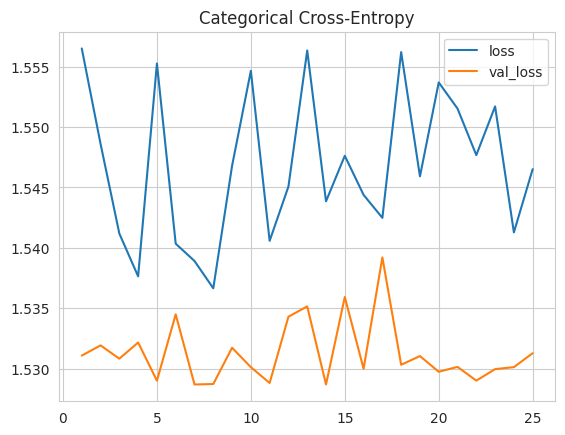

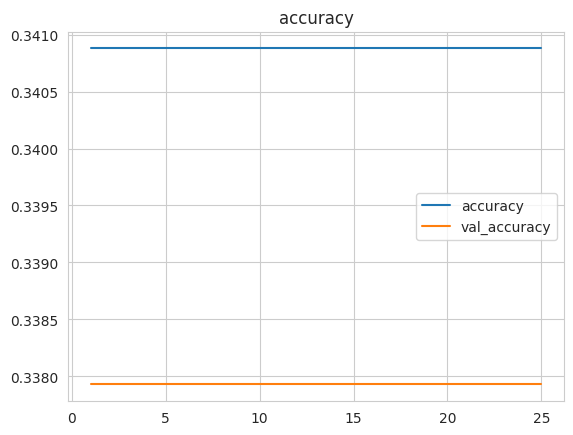

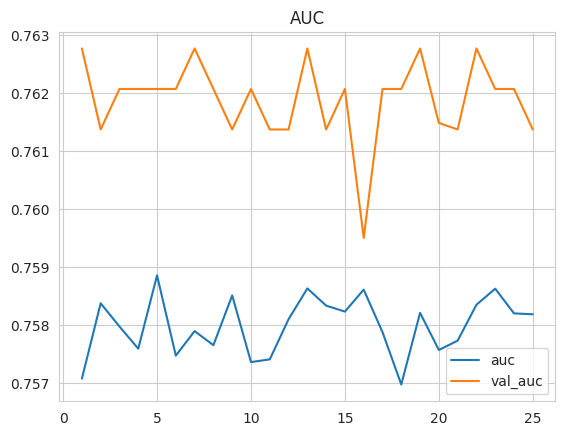

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot(title="Categorical Cross-Entropy")
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot(title="accuracy")
history_df.loc[1:, ['auc', 'val_auc']].plot(title="AUC")

In [10]:
def print_history(history) -> None:
    idx = np.argmin(history.history['val_loss'])
    print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
    print(f'Best validation auc     : {history.history["auc"][idx]}')
    print(f'Best validation loss    : {history.history["val_loss"][idx]}')

print_history(history)

Best validation accuracy: 0.33792924880981445
Best validation auc     : 0.758327841758728
Best validation loss    : 1.5286922454833984


## Conclusion vanilla 0.1
Our accuracy is quite low. There is definitely room for improvment. First off, our model is underfitting. Experimenting with Depth and Width of the neural network could help us pick up valuable patterns. There is also the issue that the input data isn't normalized, as well as the inbalance in the categorical outcomes. I will attack one of these issues at a time to see how it affects accuracy. Since normalizing inputs is almost always a good practice, that is what I will start with.

In [11]:
# Let us start by inspecting the input data
cols = X_train.columns
for i in range(0,len(cols),4):
    temp_cols = cols[i:i+4]
    print(X_train[temp_cols].describe(), '\n')

          X_Minimum     X_Maximum     Y_Minimum     Y_Maximum
count  15375.000000  15375.000000  1.537500e+04  1.537500e+04
mean     707.004943    751.393886  1.841375e+06  1.838371e+06
std      531.539440    499.451650  1.890806e+06  1.885604e+06
min        0.000000      4.000000  6.712000e+03  6.724000e+03
25%       48.000000    214.000000  6.494805e+05  6.459920e+05
50%      772.000000    788.000000  1.388373e+06  1.388398e+06
75%     1151.000000   1162.000000  2.364667e+06  2.355679e+06
max     1705.000000   1713.000000  1.298766e+07  1.298769e+07 

        Pixels_Areas   X_Perimeter   Y_Perimeter  Sum_of_Luminosity
count   15375.000000  15375.000000  15375.000000       1.537500e+04
mean     1711.285333     96.753561     64.728195       1.949845e+05
std      3815.624638    180.782003    101.740384       4.461010e+05
min         6.000000      2.000000      2.000000       2.500000e+02
25%        91.000000     15.000000     14.000000       9.962000e+03
50%       169.000000     25.0000

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pick columns with a 'large' mean, 
# I will chose 2.5 just to avoid manipulation the Log-based categories
cols_to_std = [c for c in cols if X_train[c].mean() > 2.5]

# Bundle preprocessing for numerical and categorical data
my_preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])
X_train[cols_to_std] = my_preprocessor.fit_transform(X_train)

In [13]:
X_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,...,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000
mean,4.621416e-17,8.133692e-17,-1.478853e-17,-2.495565e-17,2.403136e-17,-7.394266e-18,2.865278e-17,8.318549e-18,-2.477079e-16,4.076089e-16,...,0.031030,0.614502,0.830088,0.590354,2.479848,1.316409,1.392405,0.100312,-0.138204,0.573906
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,...,0.048031,0.222428,0.221815,0.482726,0.762567,0.469951,0.406808,0.488807,0.120656,0.332296
min,-1.330151e+00,-1.496478e+00,-9.703391e-01,-9.714164e-01,-4.469362e-01,-5.241486e-01,-6.165716e-01,-4.365397e-01,-2.932666e+00,-6.291542e+00,...,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000
25%,-1.239845e+00,-1.076003e+00,-6.303838e-01,-6.323798e-01,-4.246587e-01,-4.522365e-01,-4.986205e-01,-4.147681e-01,-5.440918e-01,-3.280118e-01,...,0.006600,0.451600,0.650000,0.000000,1.954200,1.000000,1.079200,-0.272700,-0.192400,0.257000
50%,1.222810e-01,7.329499e-02,-2.395893e-01,-2.386439e-01,-4.042157e-01,-3.969195e-01,-4.003280e-01,-3.956933e-01,1.828657e-01,-1.175343e-01,...,0.009500,0.636400,0.961500,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900
75%,8.353275e-01,8.221406e-01,2.767650e-01,2.743547e-01,-2.750059e-01,-1.645879e-01,-2.681613e-02,-2.827556e-01,7.021210e-01,4.437391e-01,...,0.019200,0.785700,1.000000,1.000000,2.822800,1.431400,1.716000,0.529400,-0.084200,0.999600
max,1.877617e+00,1.925386e+00,5.895184e+00,5.913055e+00,3.956066e+01,4.124575e+01,8.239590e+00,2.554758e+01,3.852270e+00,8.722522e+00,...,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000


In [14]:
# Get a new model with slower learning rate
model = get_model_vanilla(learning_rate=0.005)
print(f'New model: {model.name}')

early_stopping = get_early_stopping()
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

New model: Vanilla
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3851 - auc: 0.7730 - loss: 1.4474 - val_accuracy: 0.2666 - val_auc: 0.5792 - val_loss: 283352.5000
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5308 - auc: 0.9004 - loss: 1.0247 - val_accuracy: 0.3062 - val_auc: 0.6029 - val_loss: 119787.0469
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5360 - auc: 0.9064 - loss: 0.9854 - val_accuracy: 0.3509 - val_auc: 0.6304 - val_loss: 47723.8164
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4888 - auc: 0.8730 - loss: 1.2465 - val_accuracy: 0.2573 - val_auc: 0.5732 - val_loss: 113600.3594
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3253 - auc: 0.7181 - loss: 5.3386 - val_accuracy: 0.2669 - val_auc: 0.5783 - val_loss: 59410.6992
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3825 - auc: 0.7011 - loss: 7.3744 - val_accuracy: 0.3345 - val_auc: 0.6207 - val_loss: 94574.9844
Epoch 7/200
31/31 ━━━━━━━━━━━

In [15]:
# Lets inspect our results
print_history(history)

Best validation accuracy: 0.33792924880981445
Best validation auc     : 0.59843510389328
Best validation loss    : 1.6016803979873657


### Conclusion vanilla 0.2, standardized input data
Well, we did see some improvements.

# Submit the result
I have submitted several results over the time of creating this model.
1. 'Vanilla', Score: 0.54859

In [16]:
# Train and submit
X_test = test_data
X_test[cols_to_std] = my_preprocessor.transform(test_data)
y_hat = model.predict(X_test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_vanilla_001.csv', index=True)

       Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
id                                                                        
19219     0.0        0.0       0.0     0.0        0.0    0.0           1.0
19220     0.0        0.0       0.0     0.0        0.0    0.0           1.0
19221     0.0        0.0       0.0     0.0        0.0    0.0           1.0
19222     0.0        0.0       0.0     0.0        0.0    0.0           1.0
19223     0.0        0.0       0.0     0.0        0.0    0.0           1.0
